<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Mohammadreza Bagheri
### Student ID: 402300459

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 55017105.29it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 20678677.68it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 32334927.96it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13834806.66it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [3]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

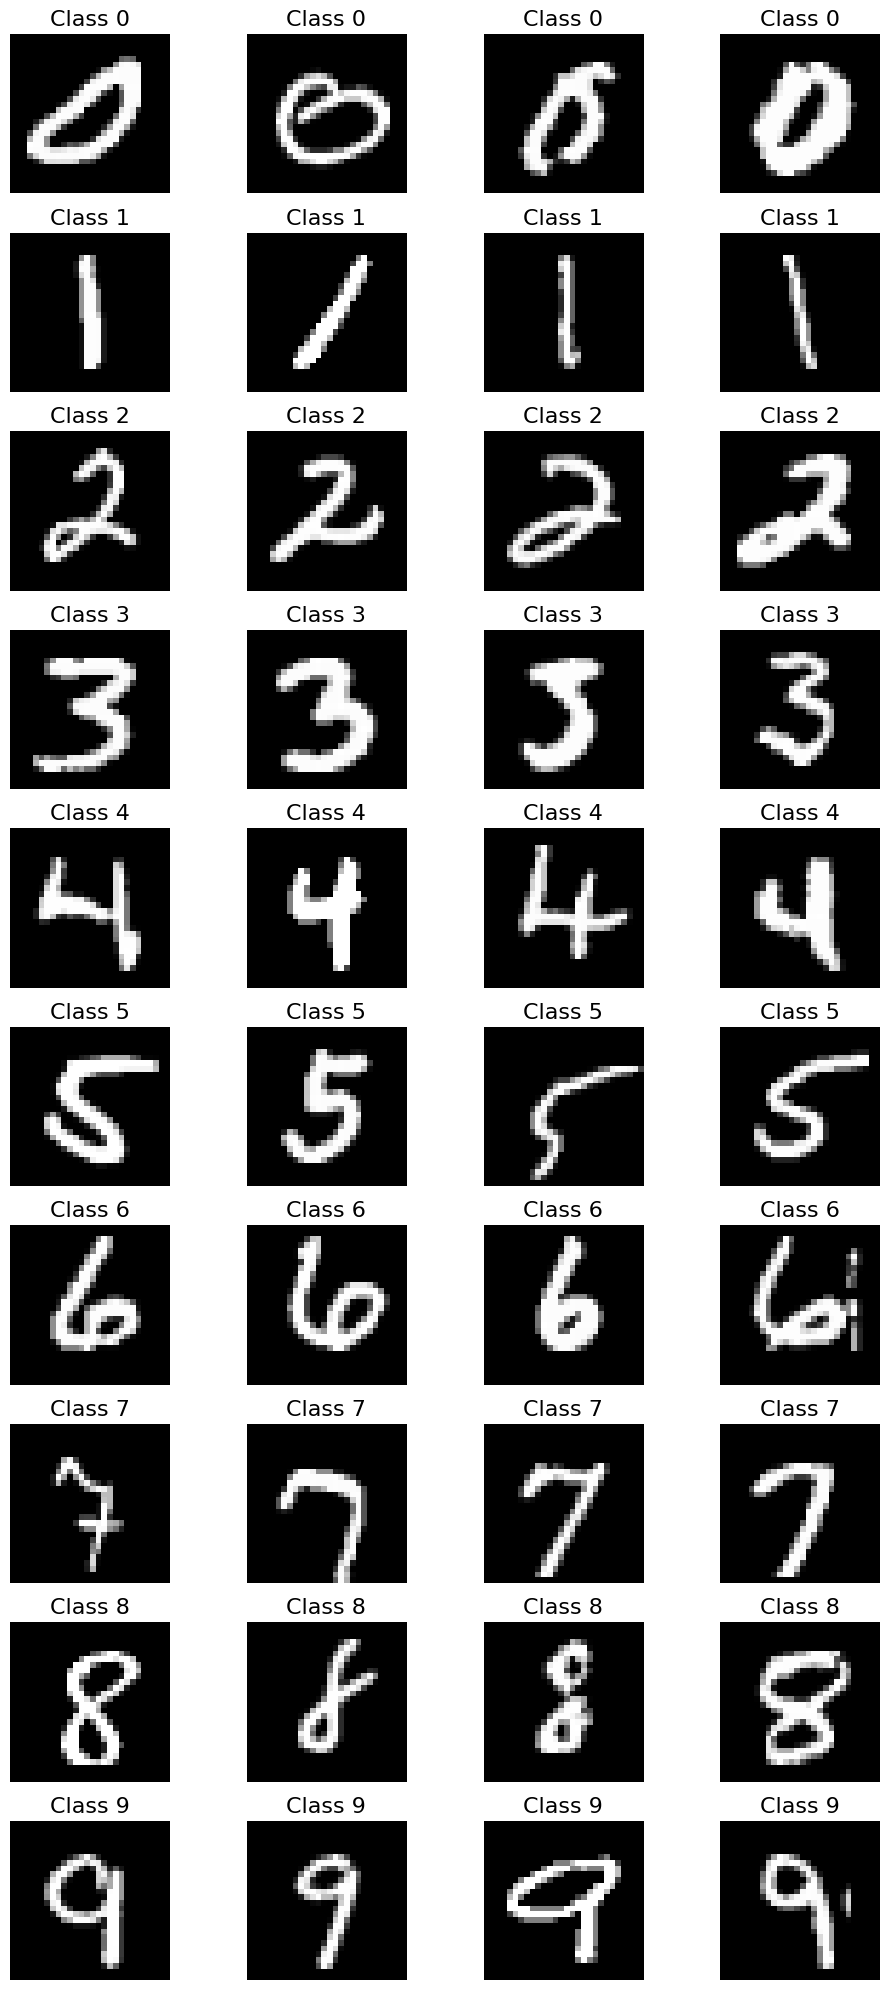

In [4]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [5]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Flatten(),
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(self.hidden_dim, self.latent_dim)
        self.fc_logvar = nn.Linear(self.hidden_dim, self.latent_dim)
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(self.latent_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.input_dim),
            nn.Sigmoid(),
            nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        sigma = torch.sqrt(torch.exp(logvar))
        z = (sigma * torch.randn_like(mu)) + mu
        return z

    def forward(self, x):
        # TODO: Implement the forward pass
        encoder_output = self.encoder(x)
        mu = self.fc_mu(encoder_output)
        logvar = self.fc_logvar(encoder_output)
        z = self.reparameterize(mu, logvar)
        x_new = self.decoder(z)
        return x_new, mu, logvar

In [6]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    num = mu.shape[0]
    reconstruction_loss = nn.functional.binary_cross_entropy(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * (1 + logvar - mu**2 - torch.exp(logvar)).sum()

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    loss = (reconstruction_loss + kl_divergence)/num
    return loss

In [7]:
# Training Loop - VAE (MLP)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process
            data = data.to(device)
            recon, mu, logvar = model(data)
            # TODO: Flatten the data and recon tensors
            print(data.shape)
            data = data.view(data.size(0), -1)
            recon = recon.view(recon.size(0), -1)
            optimizer.zero_grad()
            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)
            print(loss)
            # TODO: Backpropagation and optimization step
            loss.backward()

            optimizer.step()

            total_loss += loss.data

        avg_loss = total_loss/len(train_loader)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model  # TODO: Save the model
    # TODO: Save the best model to a file
    from google.colab import drive
    drive.mount('/content/drive')
    save_path = '/content/drive/MyDrive/DeepHW4/Q2/best_vae_mlp_model.pth'
    torch.save(model.state_dict(), 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
torch.Size([64, 1, 28, 28])
tensor(547.2082, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(546.2982, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(545.3312, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(544.6071, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(544.1680, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(543.0039, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(542.3254, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(541.4201, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(540.4044, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(539.3859, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(538.4431, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(537.5211, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(536.5103, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(535.5178, grad_f

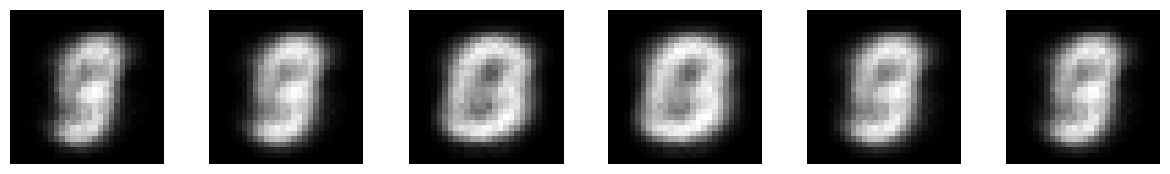


##################################################
torch.Size([64, 1, 28, 28])
tensor(199.2188, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(194.1102, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(190.9563, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(185.5010, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(196.0608, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(187.3113, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(200.1506, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(183.3150, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(196.0498, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(190.2730, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(188.6249, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(190.0815, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(185.7061, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(189.5226, grad_f

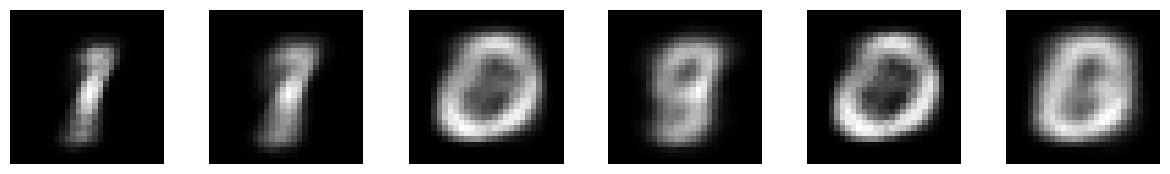


##################################################
torch.Size([64, 1, 28, 28])
tensor(189.0380, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(187.4686, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(193.2375, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(185.1230, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(182.7190, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(183.8529, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(186.7998, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(179.1178, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(191.3853, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(185.9156, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(179.7488, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(181.1769, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(173.0345, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(183.3387, grad_f

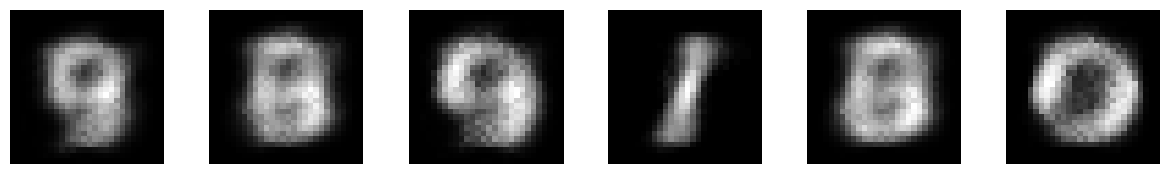


##################################################
torch.Size([64, 1, 28, 28])
tensor(172.2117, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(178.9386, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(170.2146, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(178.0907, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(174.5955, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(183.8238, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(169.1764, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(172.0074, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(175.3359, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(167.6949, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(177.5344, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(172.5166, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(179.7556, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(180.9377, grad_f

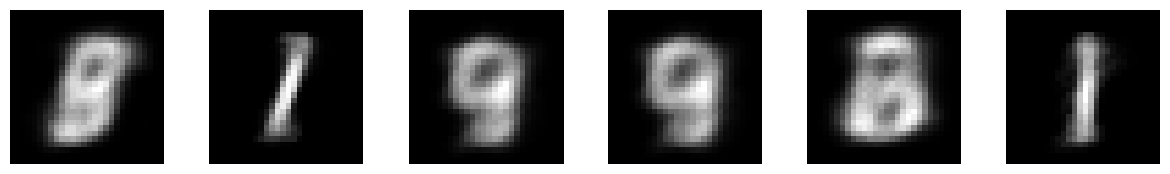


##################################################
torch.Size([64, 1, 28, 28])
tensor(169.6959, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(166.6534, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(165.0223, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(167.4887, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(169.3467, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(175.5254, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(179.3961, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(162.8020, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(172.4722, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(172.1973, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(174.7736, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(157.6970, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(169.2972, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(173.8307, grad_f

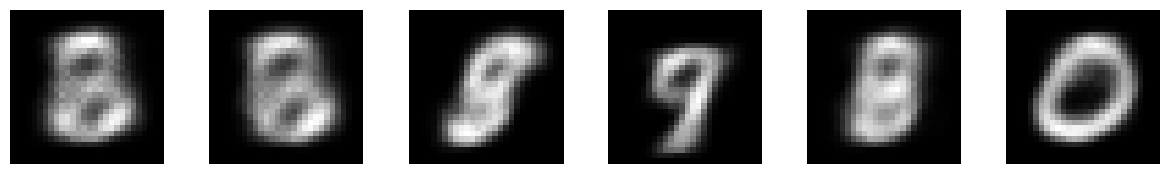


##################################################
torch.Size([64, 1, 28, 28])
tensor(169.1733, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(161.8941, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(176.4135, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(174.2708, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(167.3768, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(161.2303, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(172.5456, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(166.7015, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(179.2488, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(162.4708, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(171.0898, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(172.6982, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(167.5259, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(179.6438, grad_f

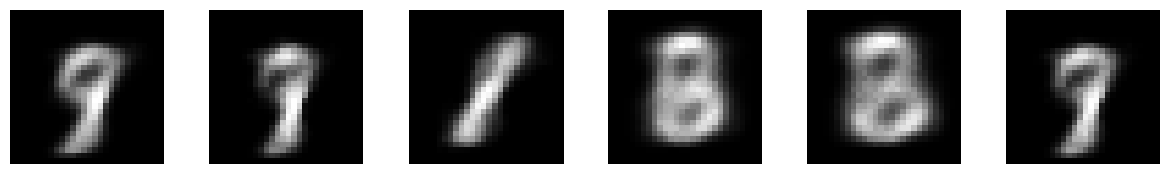


##################################################
torch.Size([64, 1, 28, 28])
tensor(171.2007, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(166.3665, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(175.1059, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(161.9784, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(177.9797, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(176.8613, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(167.1230, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(161.1468, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(164.0845, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(162.9995, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(172.7232, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(168.3422, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(165.2704, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(158.4520, grad_f

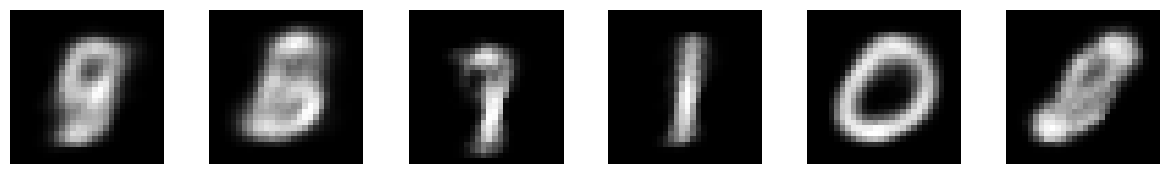


##################################################
torch.Size([64, 1, 28, 28])
tensor(168.6830, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(162.1557, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(172.9235, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(169.2612, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(170.9088, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(173.0820, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(173.2868, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(160.5939, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(158.7427, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(172.9633, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(160.7224, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(153.8069, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(164.7219, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(160.2695, grad_f

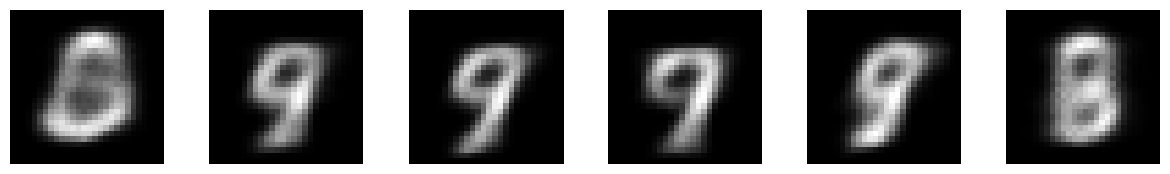


##################################################
torch.Size([64, 1, 28, 28])
tensor(171.9839, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(169.7348, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(166.8758, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(179.0063, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(174.1465, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(164.7383, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(170.3963, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(167.6182, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(159.9962, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(170.3619, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(159.5429, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(170.9546, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(167.7413, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(169.4218, grad_f

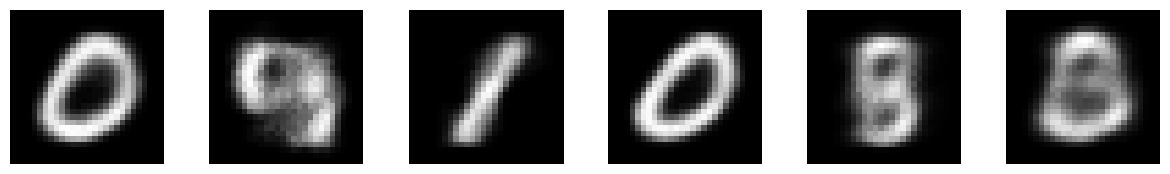


##################################################
torch.Size([64, 1, 28, 28])
tensor(160.1225, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(171.1460, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(175.7287, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(173.0524, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(165.7729, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(174.0630, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(165.6050, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(166.5644, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(173.0063, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(174.0835, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(169.5371, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(173.4254, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(164.7842, grad_fn=<DivBackward0>)
torch.Size([64, 1, 28, 28])
tensor(160.7623, grad_f

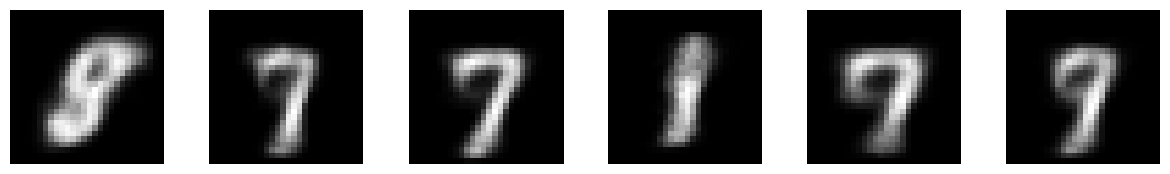

Mounted at /content/drive
Best model saved as 'best_vae_mlp_model.pth'


In [8]:
# Train VAE-MLP
vae_mlp = VAE_MLP(input_dim =28*28*1, hidden_dim=20, latent_dim=2)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [50]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Linear(self.input_dim + self.num_classes, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(self.hidden_dim, self.latent_dim)
        self.fc_logvar = nn.Linear(self.hidden_dim, self.latent_dim)
        self.fc_class = nn.Linear(self.num_classes, self.latent_dim)

        # TODO: Define the architecture of the decoder
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(self.latent_dim + self.num_classes, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.input_dim),
            nn.Sigmoid(),
            nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        sigma = torch.sqrt(torch.exp(logvar))
        z = (sigma * torch.randn_like(mu)) + mu
        return z

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        x = torch.cat((x, y), dim=1)

        # TODO: Implement the forward pass
        encoder_output = self.encoder(x)
        hidden = None
        mu = self.fc_mu(encoder_output)
        logvar = self.fc_logvar(encoder_output)
        z = self.reparameterize(mu, logvar)

        class_logits = self.fc_class(y)
        decoder_input = torch.cat((z, y), dim=1)
        reconstructed = self.decoder(decoder_input)

        return reconstructed, mu, logvar, class_logits


In [51]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    num = mu.shape[0]
    data = data.view(data.size(0), -1)
    recon = recon.view(recon.size(0),-1)
    # TODO: Implement the reconstruction loss
    reconstruction_loss = nn.functional.binary_cross_entropy(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * (1 + logvar - mu**2 - torch.exp(logvar)).sum()

    # TODO: Implement the cross-entropy loss for class prediction
    ce_loss = (reconstruction_loss + kl_divergence)/num

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    return ce_loss


In [52]:
def one_hot_enc(labels, class_size):
  targets = torch.zeros(labels.size(0), class_size)
  for i, lbl in enumerate(labels):
    targets[i, lbl] = 1
  return targets

In [53]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = one_hot_enc(labels, class_size=10).to(device)

            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon_batch, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon_batch, data, mu, logvar, class_logits, labels)

            # TODO: Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            total_loss += loss.data
            optimizer.step()

        avg_loss = total_loss/len(train_loader)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model

    # TODO: Save the best model to a file
    from google.colab import drive
    drive.mount('/content/drive')
    save_path = '/content/drive/MyDrive/DeepHW4/Q2/best_cvae_mlp_model.pth'
    torch.save(model.state_dict(), 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")






##################################################
CVAE-MLP Epoch [1/10], Loss: 221.79164123535156
Sample Images:


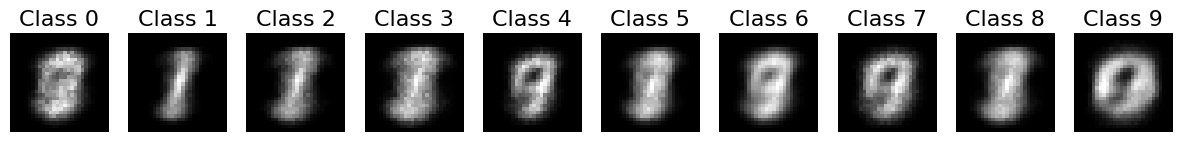


##################################################
CVAE-MLP Epoch [2/10], Loss: 178.7768096923828
Sample Images:


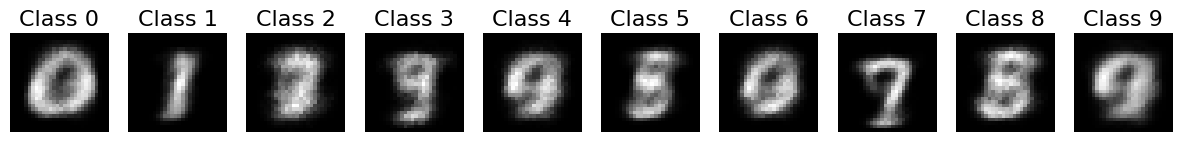


##################################################
CVAE-MLP Epoch [3/10], Loss: 164.94091796875
Sample Images:


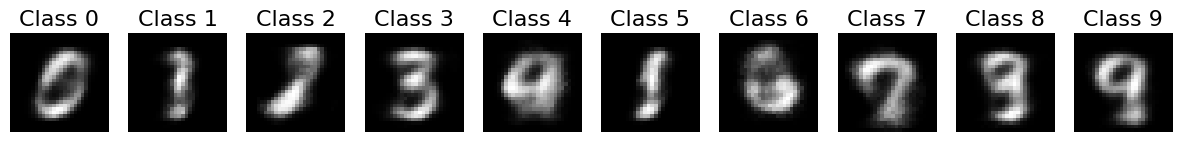


##################################################
CVAE-MLP Epoch [4/10], Loss: 156.2736053466797
Sample Images:


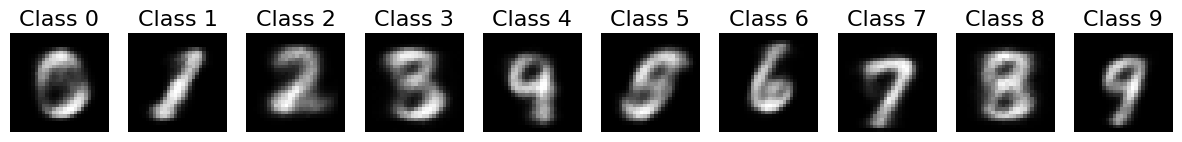


##################################################
CVAE-MLP Epoch [5/10], Loss: 153.597412109375
Sample Images:


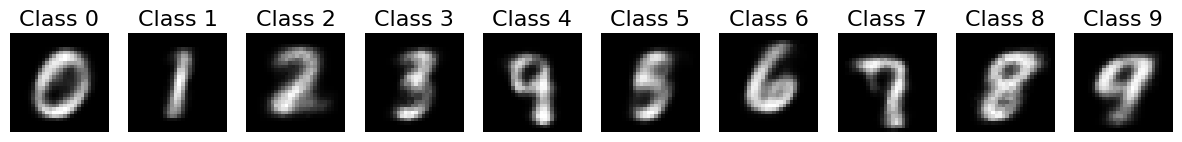


##################################################
CVAE-MLP Epoch [6/10], Loss: 151.6427764892578
Sample Images:


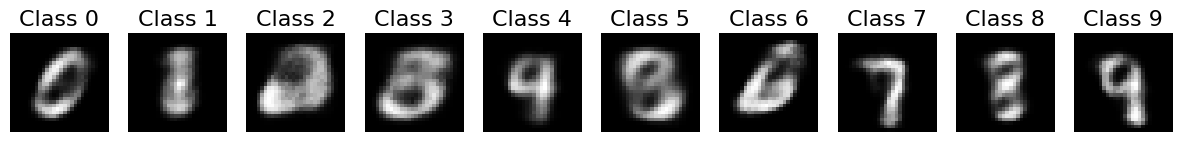


##################################################
CVAE-MLP Epoch [7/10], Loss: 150.29173278808594
Sample Images:


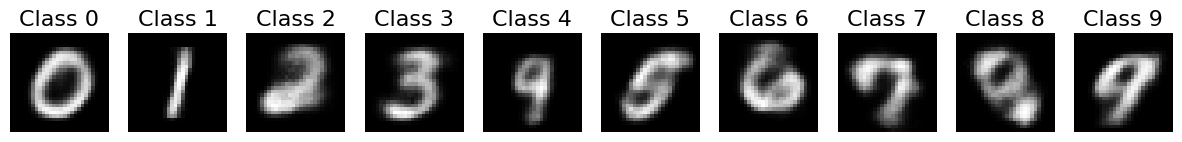


##################################################
CVAE-MLP Epoch [8/10], Loss: 149.17684936523438
Sample Images:


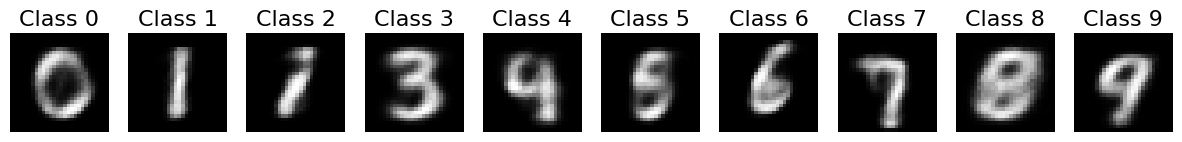


##################################################
CVAE-MLP Epoch [9/10], Loss: 148.09194946289062
Sample Images:


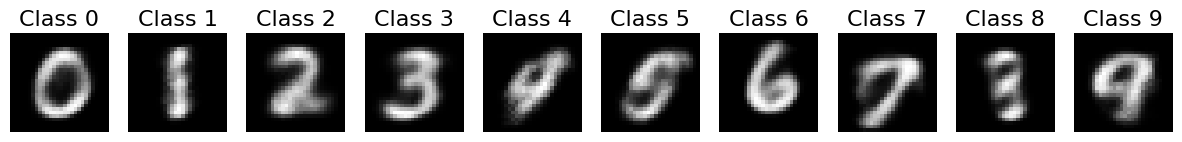


##################################################
CVAE-MLP Epoch [10/10], Loss: 147.00192260742188
Sample Images:


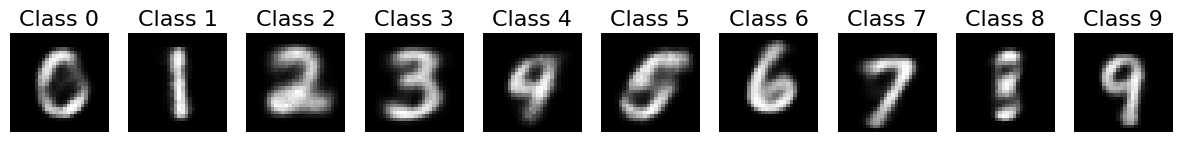

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Best model saved as 'best_cvae_mlp_model.pth'


In [54]:
cvae_mlp = CVAE_MLP(input_dim =28*28*1, hidden_dim=20, latent_dim=2, num_classes=10)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


In [ ]:
mu_arr = []
var_arr = []
for i in range(len(train_dataset)):
    _,mu,var = vae_mlp.forward(train_dataset[i][0])
    label = train_dataset[i][1]
    mu_arr.append([mu,label])
    var_arr.append([var,label])

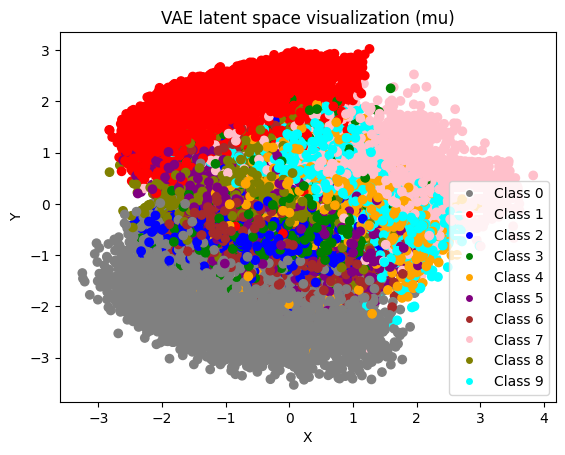

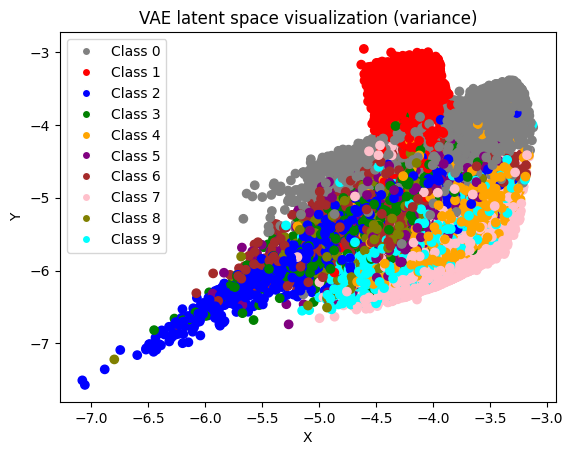

In [45]:
import matplotlib.pyplot as plt

class_colors = {
    0: 'gray',
    1: 'red',
    2: 'blue',
    3: 'green',
    4: 'orange',
    5: 'purple',
    6: 'brown',
    7: 'pink',
    8: 'olive',
    9: 'cyan'
}


x = [point[0][0][0].item() for point in mu_arr]
y = [point[0][0][1].item() for point in mu_arr]


labels = [class_colors[class_label[1]] for class_label in mu_arr]


plt.scatter(x, y, c=labels)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('VAE latent space visualization (mu)')

# Add a legend
legend_elements = [
    plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, label=f'Class {class_label}')
    for class_label, color in class_colors.items()
]
plt.legend(handles=legend_elements)

# Show the plot
plt.show()





x = [point[0][0][0].item() for point in var_arr]
y = [point[0][0][1].item() for point in var_arr]


labels = [class_colors[class_label[1]] for class_label in mu_arr]


plt.scatter(x, y, c=labels)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('VAE latent space visualization (variance)')

# Add a legend
legend_elements = [
    plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, label=f'Class {class_label}')
    for class_label, color in class_colors.items()
]
plt.legend(handles=legend_elements)

# Show the plot
plt.show()


In [ ]:
mu_arr = []
var_arr = []
for i in range(len(train_dataset)):
    label = train_dataset[i][1]
    labels_one_hot = one_hot_enc(torch.tensor([label]), class_size=10).to(device)
    _,mu,var,_ = cvae_mlp.forward(train_dataset[i][0],labels_one_hot)

    mu_arr.append([mu,label])
    var_arr.append([var,label])

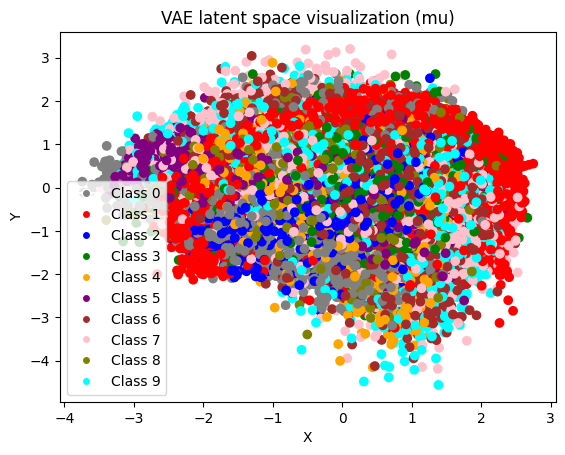

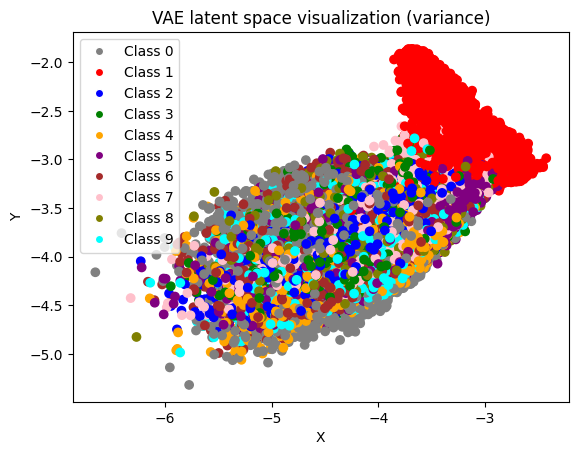

In [62]:
import matplotlib.pyplot as plt

class_colors = {
    0: 'gray',
    1: 'red',
    2: 'blue',
    3: 'green',
    4: 'orange',
    5: 'purple',
    6: 'brown',
    7: 'pink',
    8: 'olive',
    9: 'cyan'
}


x = [point[0][0][0].item() for point in mu_arr]
y = [point[0][0][1].item() for point in mu_arr]


labels = [class_colors[class_label[1]] for class_label in mu_arr]


plt.scatter(x, y, c=labels)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('VAE latent space visualization (mu)')

# Add a legend
legend_elements = [
    plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, label=f'Class {class_label}')
    for class_label, color in class_colors.items()
]
plt.legend(handles=legend_elements)

# Show the plot
plt.show()





x = [point[0][0][0].item() for point in var_arr]
y = [point[0][0][1].item() for point in var_arr]


labels = [class_colors[class_label[1]] for class_label in mu_arr]


plt.scatter(x, y, c=labels)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('VAE latent space visualization (variance)')

# Add a legend
legend_elements = [
    plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, label=f'Class {class_label}')
    for class_label, color in class_colors.items()
]
plt.legend(handles=legend_elements)

# Show the plot
plt.show()
